# Natural Gas Predictor
## This notebook is designed to give some more insight to given data and try to train neural network with chosen attributes

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from math import ceil, floor
import numpy as np
from sklearn.model_selection import train_test_split

FILE_URL = 'https://www.eia.gov/opendata/bulk/NG.zip'
SPOT_PRICE_DAILY_ID = 'NG.RNGWHHD.D'
MAIN_STORAGE_ID = 'NG.NW2_EPG0_SWO_R48_BCF.W'
# NG.N5020US2.M - Total U.S. Natural Gas Storage Monthly. Can be incorporated later to enhance the model.
ALL_IDS = [SPOT_PRICE_DAILY_ID,
           'NG.NW2_EPG0_SWO_R48_BCF.W', 'NG.N9070US2.M', 'NG.N9140US1.M', 'NG.N9130US2.M']

## Download latest version of natural gas info file and unzip it

In [11]:
import urllib.request

_ = urllib.request.urlretrieve(FILE_URL, "NG.zip")

In [12]:
from zipfile import ZipFile
  
with ZipFile("NG.zip", 'r') as nat_gas_zipped:
    nat_gas_zipped.extractall()

## Open the file and drop rows without data


In [13]:
with open("NG.txt", "r") as f:
    df = pd.read_json(f, lines=True)

In [14]:
df = df[df['data'].notna()]

In [15]:
df.columns

Index(['series_id', 'name', 'units', 'f', 'unitsshort', 'description',
       'copyright', 'source', 'start', 'end', 'last_updated', 'data',
       'iso3166', 'geography', 'geography2', 'category_id',
       'parent_category_id', 'notes', 'childseries'],
      dtype='object')

### Load Futures Prices

In [41]:
def read_csv_autoencoding(path):
    for enc in ['utf-8', 'utf-8-sig', 'latin1', 'cp1250']:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"✅ Loaded {path} using {enc}")
            return df
        except Exception as e:
            continue
    raise ValueError(f"❌ Could not read {path} with common encodings")

# --- Wczytanie trzech plików ---
futures = read_csv_autoencoding("NewData/Natural Gas Futures Historical Data.csv")

# --- Normalizacja nazw kolumn ---
futures.rename(columns={c: f"Futures {c}" for c in futures.columns if c != "Date"}, inplace=True)
futures.rename(columns={"Date": "date"}, inplace=True)

# --- Konwersja dat ---
futures["date"] = pd.to_datetime(futures["date"], errors="coerce")

# # --- Połączenie wg daty ---
# merged = pd.merge(futures, spot, on="date", how="outer")

# # --- Sortowanie wg daty ---
# merged.sort_values("date", inplace=True)

# print(merged.tail())

# # --- Zapis do CSV w poprawnym kodowaniu (UTF-8 z BOM, dla Excel) ---
# merged.to_csv("merged_gas_data.csv", index=False, encoding="utf-8-sig")

✅ Loaded NewData/Natural Gas Futures Historical Data.csv using utf-8


## Show series which are related to interesting data


In [17]:
def read_row_of_data(row_name=None, row_id=None, series_name=None):
    if row_name:
        row_filter = df['name'] == row_name
    elif row_id:
        row_filter = df['series_id'] == row_id
        row_name = df[row_filter]['name'].to_list()[0]
    data = df[row_filter]['data'].to_list()
    try:
        observation_dates = [datetime.datetime.strptime(
            el[0], '%Y%m%d').date() for el in data[0]]
    except ValueError as e:
        try:
            observation_dates = [datetime.datetime.strptime(
                el[0], '%Y%m').date() for el in data[0]]
        except ValueError as e:
            observation_dates = [datetime.datetime.strptime(
                el[0], '%Y').date() for el in data[0]]
    return pd.Series(
        data=[el[1] for el in data[0]], index=pd.DatetimeIndex(observation_dates), name=row_name)

### Looking for production Data

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df[(df['name'].str.contains('U.S.')) & (df['name'].str.contains(
        'Production')) & (df['f'].isin(['D', 'W', 'M']))][['name', 'series_id']])

,name,series_id
88,"U.S. Natural Gas Plant Liquids Production, Monthly",NG.N9060US2.M
89,"U.S. Dry Natural Gas Production, Monthly",NG.N9070US1.M
90,"U.S. Dry Natural Gas Production, Monthly",NG.N9070US2.M
143,"U.S. Natural Gas Marketed Production, Monthly",NG.N9050US2.M
148,"U.S. Natural Gas Plant Liquids Production, Gaseous Equivalent, Monthly",NG.N9060US1.M
1120,"U.S. Natural Gas Marketed Production (Wet), Monthly",NG.N9050US1.M


### Checking duplicate series for storage

In [19]:
series_to_check = ['NG.N5020US2.M', MAIN_STORAGE_ID]

data_to_plot = pd.concat([read_row_of_data(row_id=series_id) for series_id in series_to_check], axis=1, join='outer')
data_to_plot.tail(15)

,"U.S. Total Natural Gas in Underground Storage (Working Gas), Monthly","Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly"
2025-07-25,NaN,3123.0
2025-08-01,3328548.0,3130.0
2025-08-08,NaN,3186.0
2025-08-15,NaN,3199.0
2025-08-22,NaN,3217.0
2025-08-29,NaN,3272.0
2025-09-05,NaN,3343.0
2025-09-12,NaN,3433.0
2025-09-19,NaN,3508.0
2025-09-26,NaN,3561.0


### Saving series names, description and code to file to digest it with use of Chat GPT

In [20]:
columns = df.columns.to_list()
columns.remove('data')
df[columns].to_csv('NG_series_metadata.csv', index=False)

### Merging all possible data and exploring

In [43]:
all_data_list = []
for name in df['name']:
    data_for_series = read_row_of_data(row_name=name)
    if data_for_series.index.has_duplicates:
        print("Duplicates in element name: ", getattr(data_for_series, "name", None))
        print(data_for_series.index[data_for_series.index.duplicated()])
        print("Skipping...")
        continue
    all_data_list.append(data_for_series)
all_data_df = pd.concat(all_data_list, axis=1, join='outer')
# Remove futures as they will be added from different file
all_data_df = all_data_df[[col for col in all_data_df.columns if "Futures" not in col]]

Duplicates in element name:  U.S. Crude Oil Rotary Rigs in Operation, Monthly
DatetimeIndex(['2025-04-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Natural Gas Rotary Rigs in Operation, Monthly
DatetimeIndex(['2025-04-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Onshore Crude Oil and Natural Gas Rotary Rigs in Operation, Annual
DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Crude Oil Rotary Rigs in Operation, Annual
DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Natural Gas Rotary Rigs in Operation, Annual
DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Crude Oil and Natural Gas Rotary Rigs in Operation, Annual
DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq=None)
Skipping...


In [44]:
all_data_df = pd.concat([all_data_df, futures.set_index('date')], axis=1, join='outer')

In [53]:
all_data_df = all_data_df.sort_index()
all_data_df = all_data_df.fillna(method='ffill')
all_data_df = all_data_df.loc[:, ~
                                     all_data_df.columns.duplicated()].copy()
all_data_df = all_data_df[~all_data_df[['Henry Hub Natural Gas Spot Price, Daily', 'Futures Price', 'Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly']].isna().any(axis=1)]

In [54]:
len(all_data_df.columns)

15564

In [55]:
print([col for col in all_data_df.columns if "Futures" in col])

['Futures Price', 'Futures Open', 'Futures High', 'Futures Low', 'Futures Vol.', 'Futures Change %']


In [58]:
all_data_df['Futures Price'].dtype

dtype('float64')

In [59]:
num_df = all_data_df.apply(pd.to_numeric, errors='coerce')
correlations_df = num_df.corrwith(other=num_df['Futures Price'])

In [108]:
# show series that has strong correlation with price of natural gas

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(correlations_df.loc[(~correlations_df.index.str.contains('price')) & (~correlations_df.index.str.contains('Price')) & (~correlations_df.index.str.contains('Annual')) & ((correlations_df >= 0.7) | (correlations_df <= -0.7))])

Noyes, MN Natural Gas Pipeline Imports From Canada, Monthly                 0.770253
Eagle Pass, TX Natural Gas Pipeline Exports to Mexico, Monthly              0.872007
Corpus Christi, TX Liquefied Natural Gas Exports to Panama, Monthly        -0.714612
St. Clair, MI Natural Gas Pipeline Exports to Canada, Monthly               0.838778
McAllen, TX Natural Gas Pipeline Exports to Mexico, Monthly                 0.714388
Port of Morgan, MT Natural Gas Pipeline Imports From Canada, Monthly        0.809627
Sherwood, ND Natural Gas Pipeline Imports From Canada, Monthly              0.782277
Jacksonville, FL Liquefied Natural Gas Exports to All Countries, Monthly    0.713923
Sweetgrass, MT Liquefied Natural Gas Imports from Canada, Monthly          -0.822323
Sweetgrass, MT Liquefied Natural Gas Imports from All Countries, Monthly   -0.822323
Futures Open                                                                0.995405
Futures High                                                     

As you can see there are not too much Series with very strong (over 0.7 or under -0.7) correlation with NG price. Exports and imports to various countries are irrelevant because they are aggregated in total import/export series

## Plot data about daily prices during a year


In [76]:
price_df = all_data_df[['Henry Hub Natural Gas Spot Price, Daily', 'Futures Price']]
now_datetime = datetime.datetime.now()

In [77]:
grouped_price_df = price_df.groupby(price_df.index.year)

In [ ]:
def get_prices_for_year(df, column, year):
    dr = pd.date_range(datetime.datetime(2000, 1, 1),
                       datetime.datetime(2000, 12, 31))
    curr_group = df.get_group(year)
    new_list = []
    for date in dr:
        query = curr_group[(curr_group.index.month == date.month) & (
            curr_group.index.day == date.day)]
        new_list.append(None if query.empty else query.iloc[0][column])
    return pd.Series(new_list, index=dr, name=year).dropna()

## Plot for seasonal spot and future prices from 2016 till now

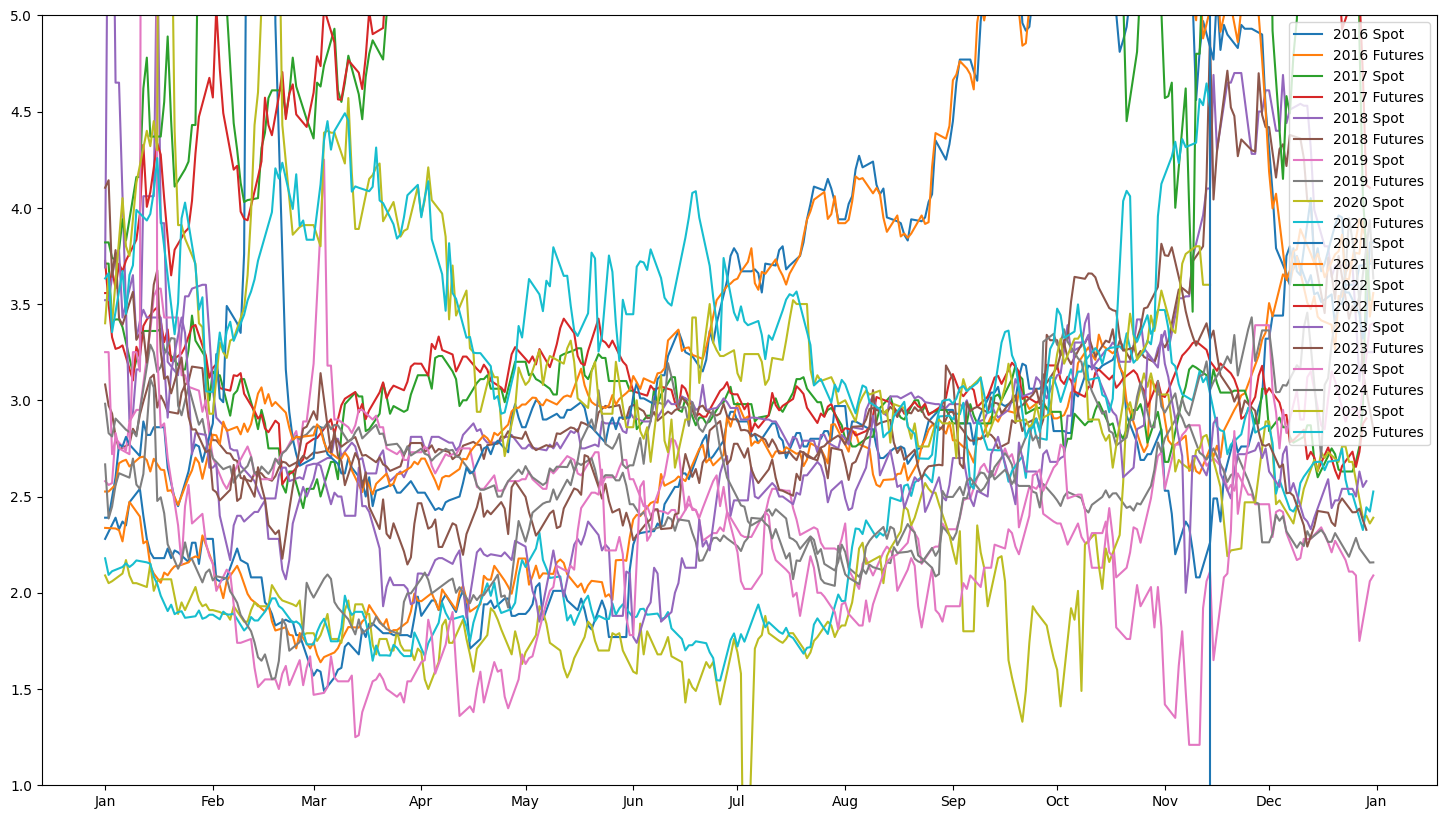

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(18, 10))
for key in grouped_price_df.groups.keys():
    if key > 2015:
        md_prices = get_prices_for_year(grouped_price_df, 'Henry Hub Natural Gas Spot Price, Daily', key)
        # md_prices = md_prices / md_prices.iloc[0]
        futures_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key)
        # futures_prices = futures_prices / futures_prices.iloc[0]
        # plt.plot(grouped_price_df.get_group(key).index.to_series().apply(lambda s: datetime.date(1, s.month, s.day)), grouped_price_df.get_group(key))
        plt.plot(md_prices, label=f'{key} Spot')
        plt.plot(futures_prices, label=f'{key} Futures')
# plt.xlim(datetime.datetime(2000, 11, 1), datetime.datetime(2000, 11, 30))
plt.ylim(1, 5)
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day))
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

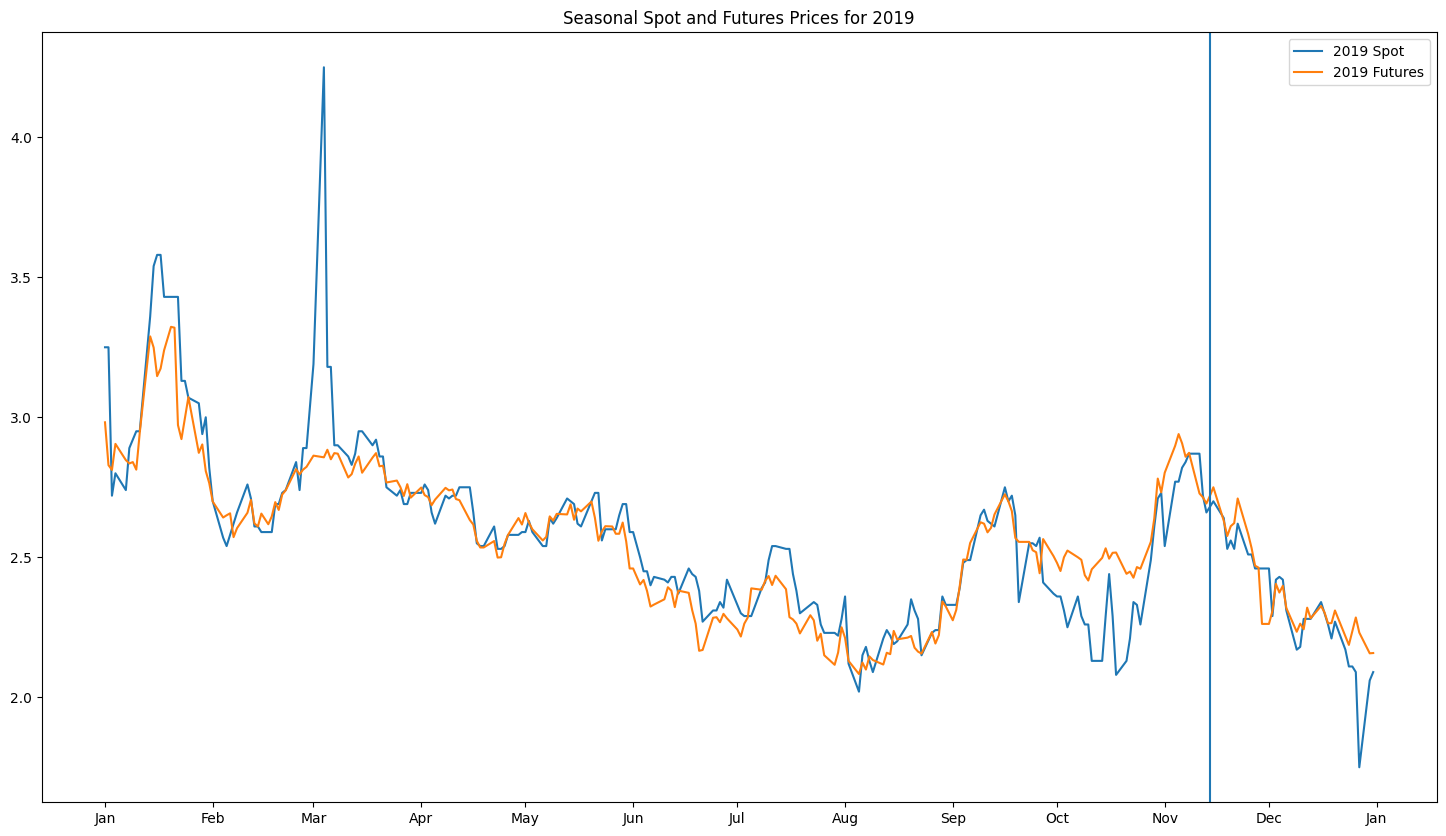

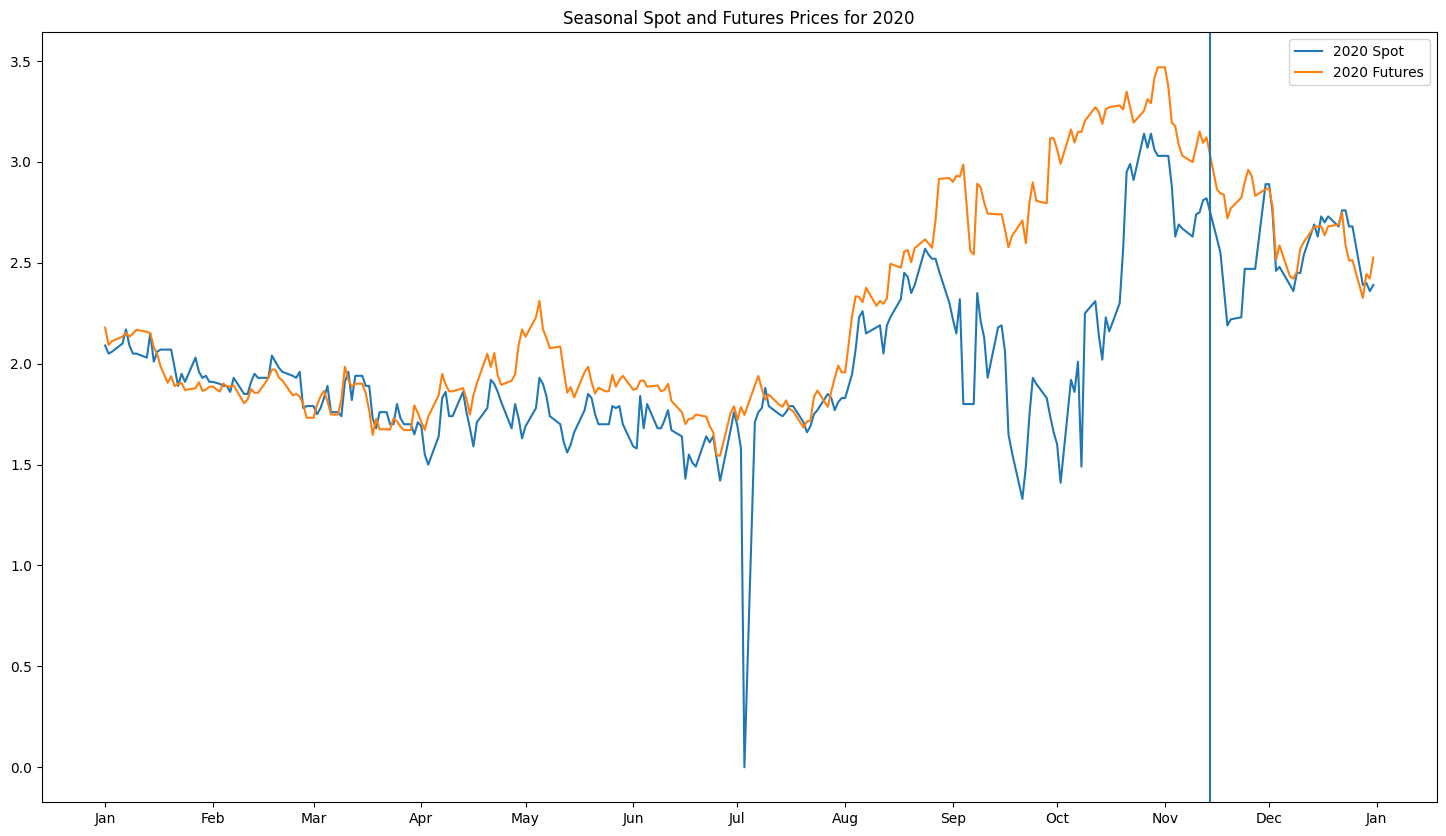

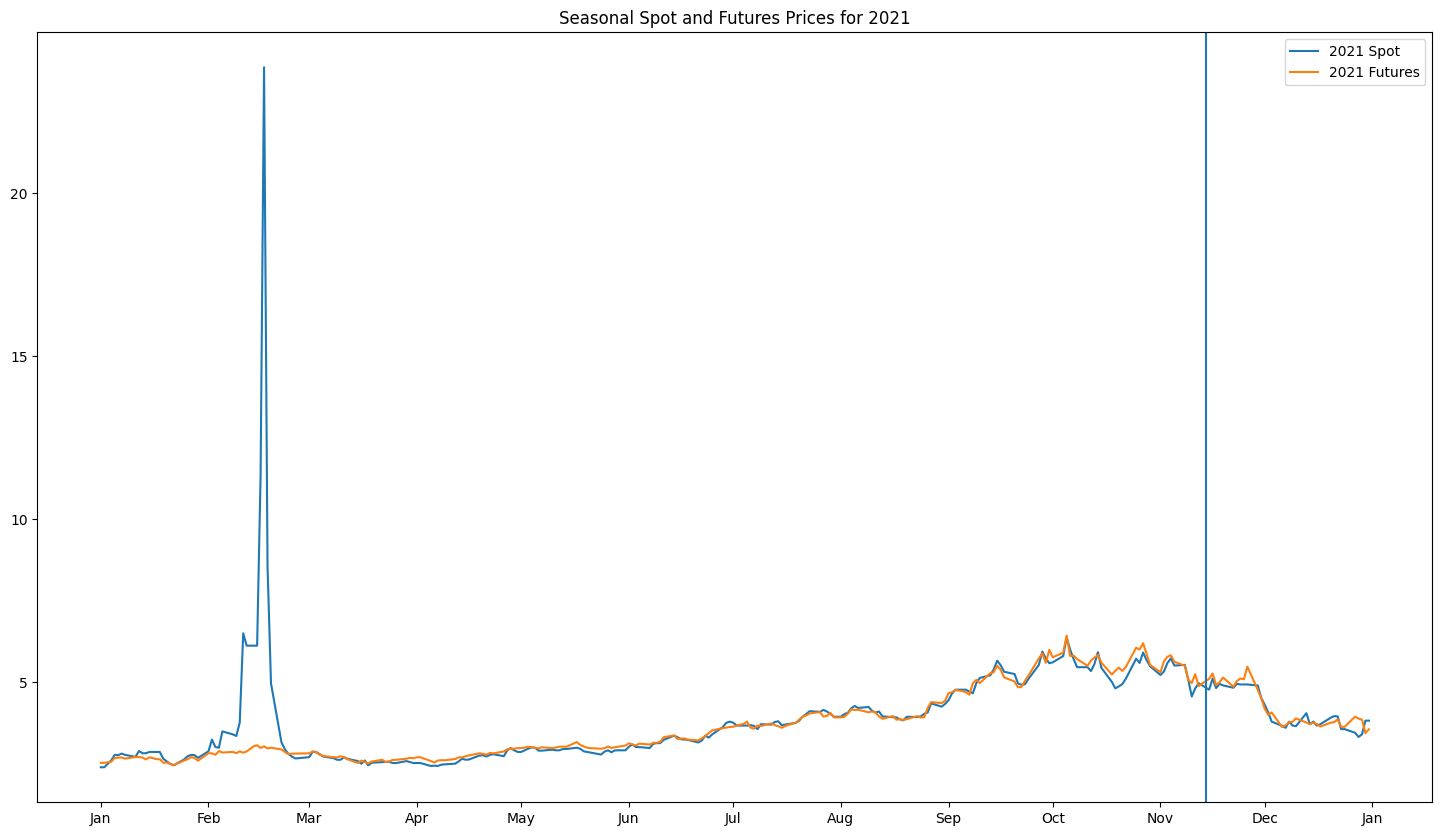

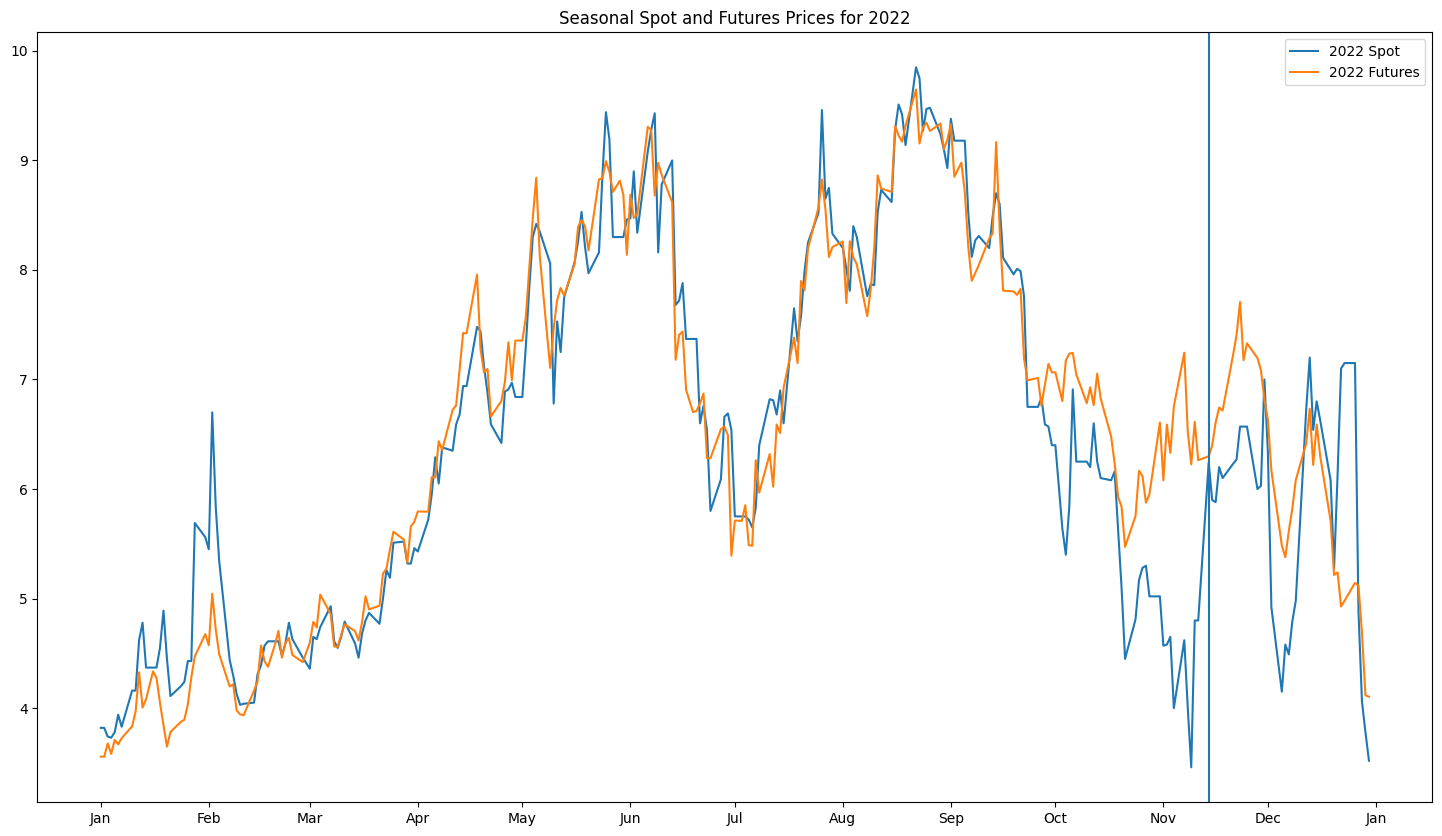

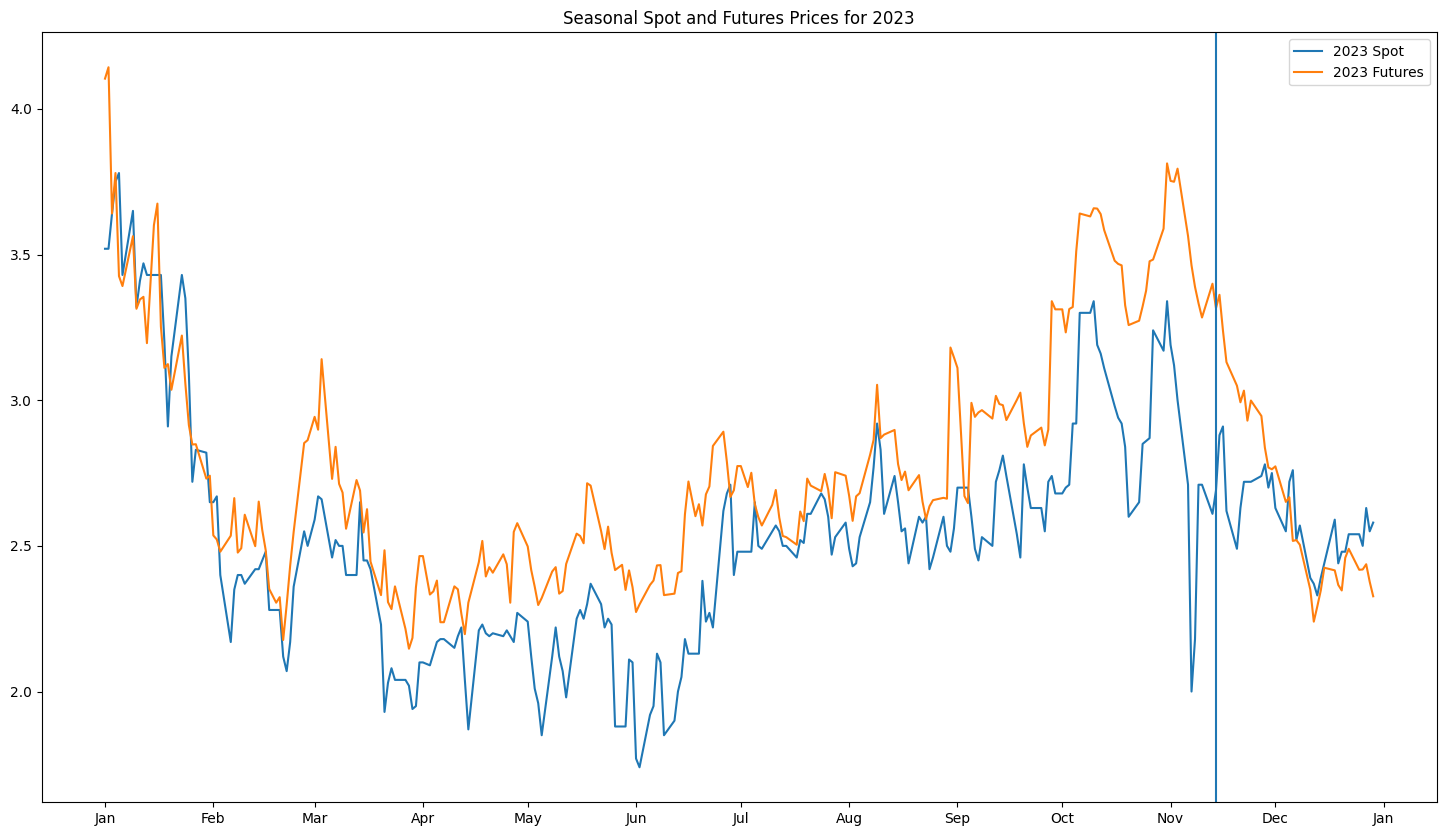

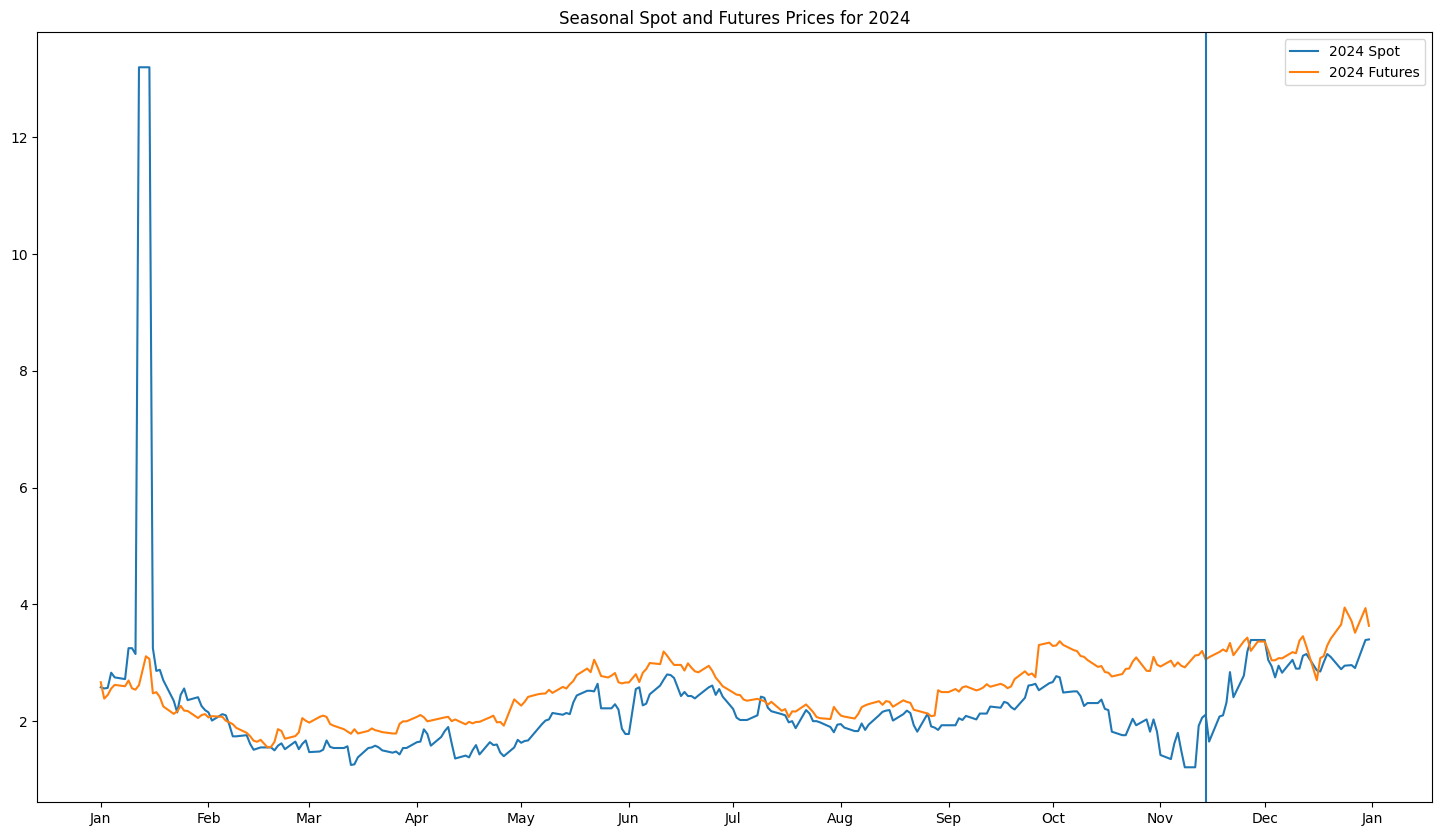

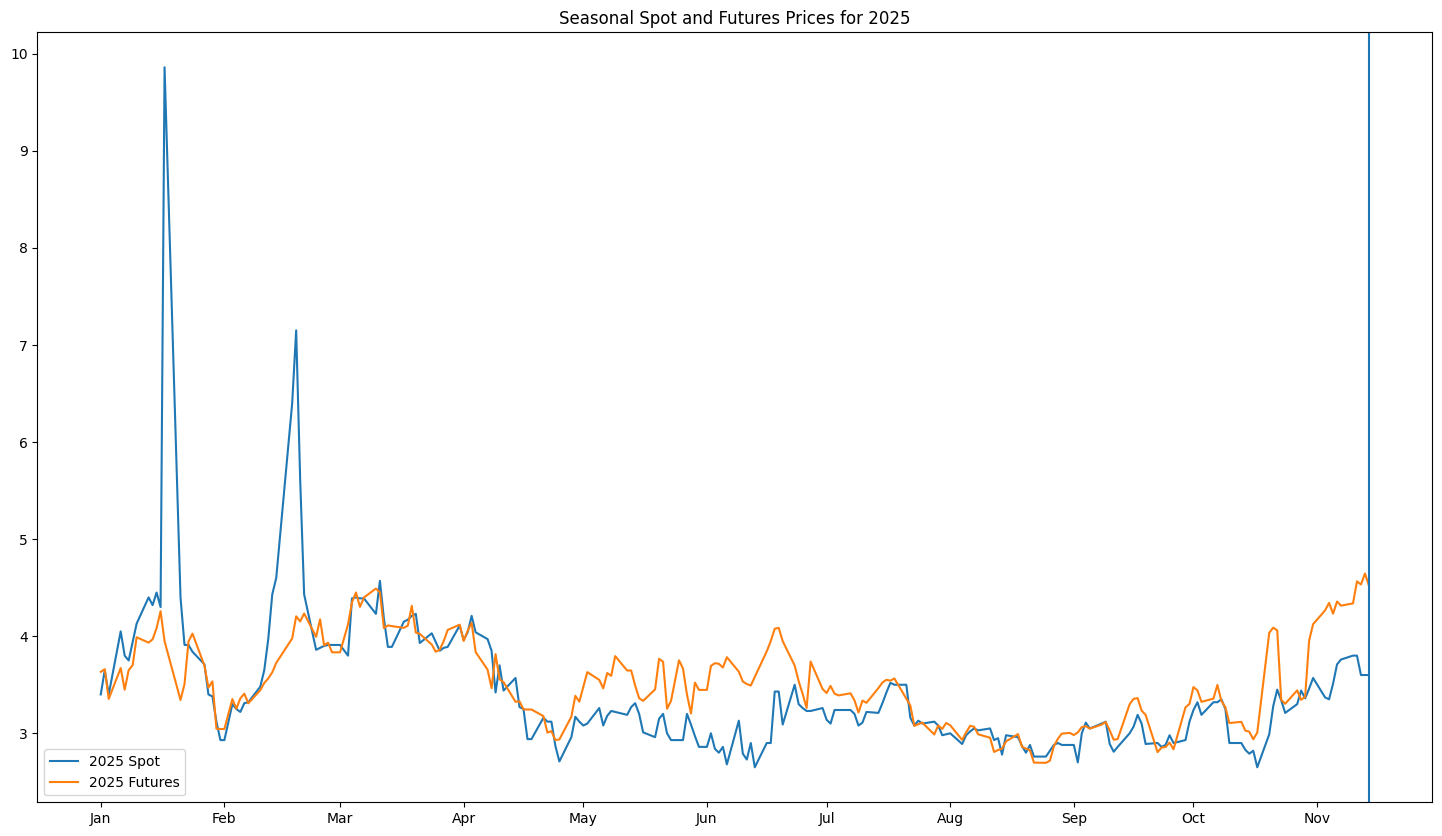

In [111]:
for key in grouped_price_df.groups.keys():
    if key > 2018:
        plt.figure(figsize=(18, 10))
        md_prices = get_prices_for_year(grouped_price_df, 'Henry Hub Natural Gas Spot Price, Daily', key)
        futures_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key)
        plt.plot(md_prices, label=f'{key} Spot')
        plt.plot(futures_prices, label=f'{key} Futures')
        plt.title(f'Seasonal Spot and Futures Prices for {key}')
        plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day))
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        plt.show()

# October - December seasonality

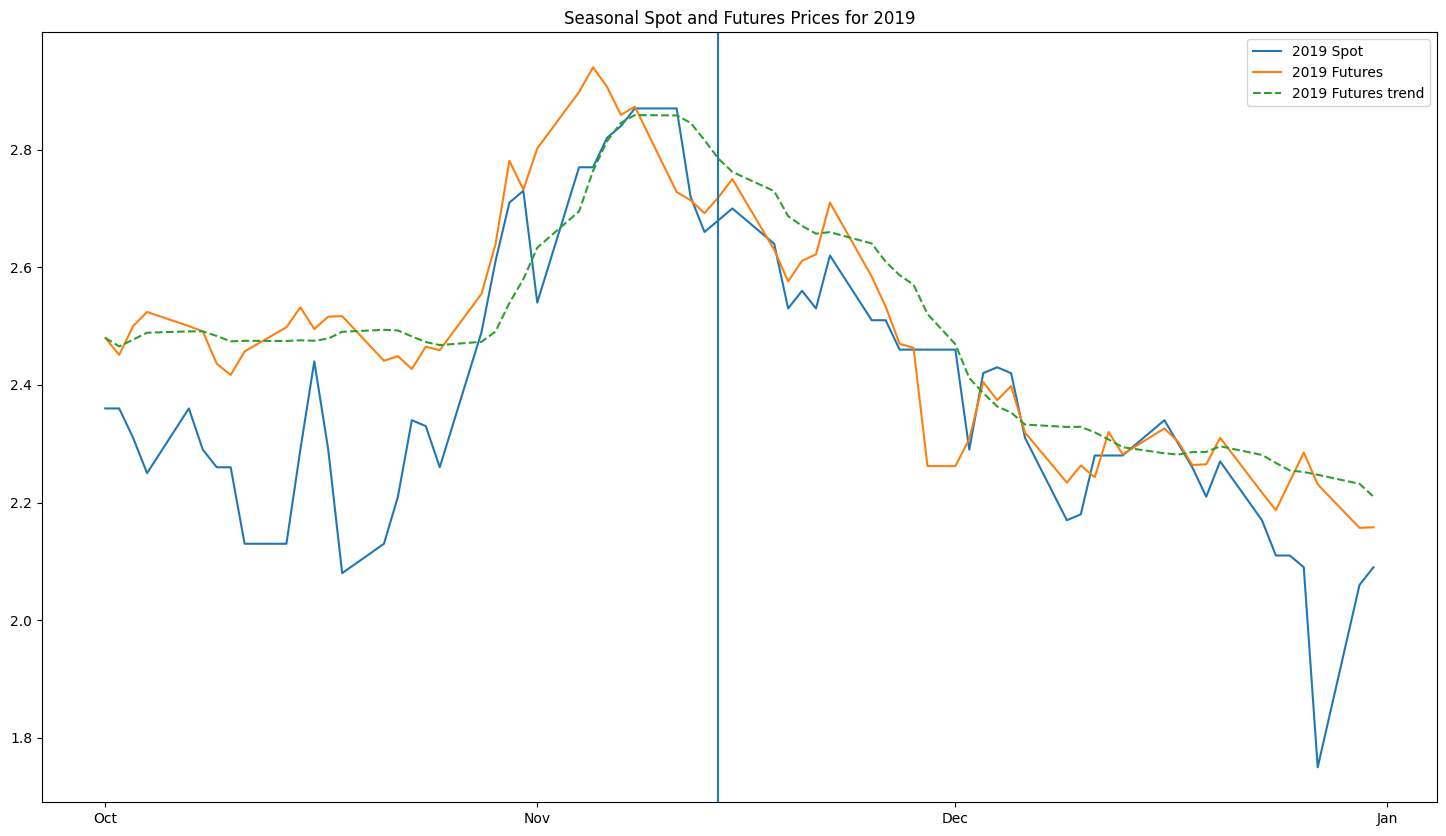

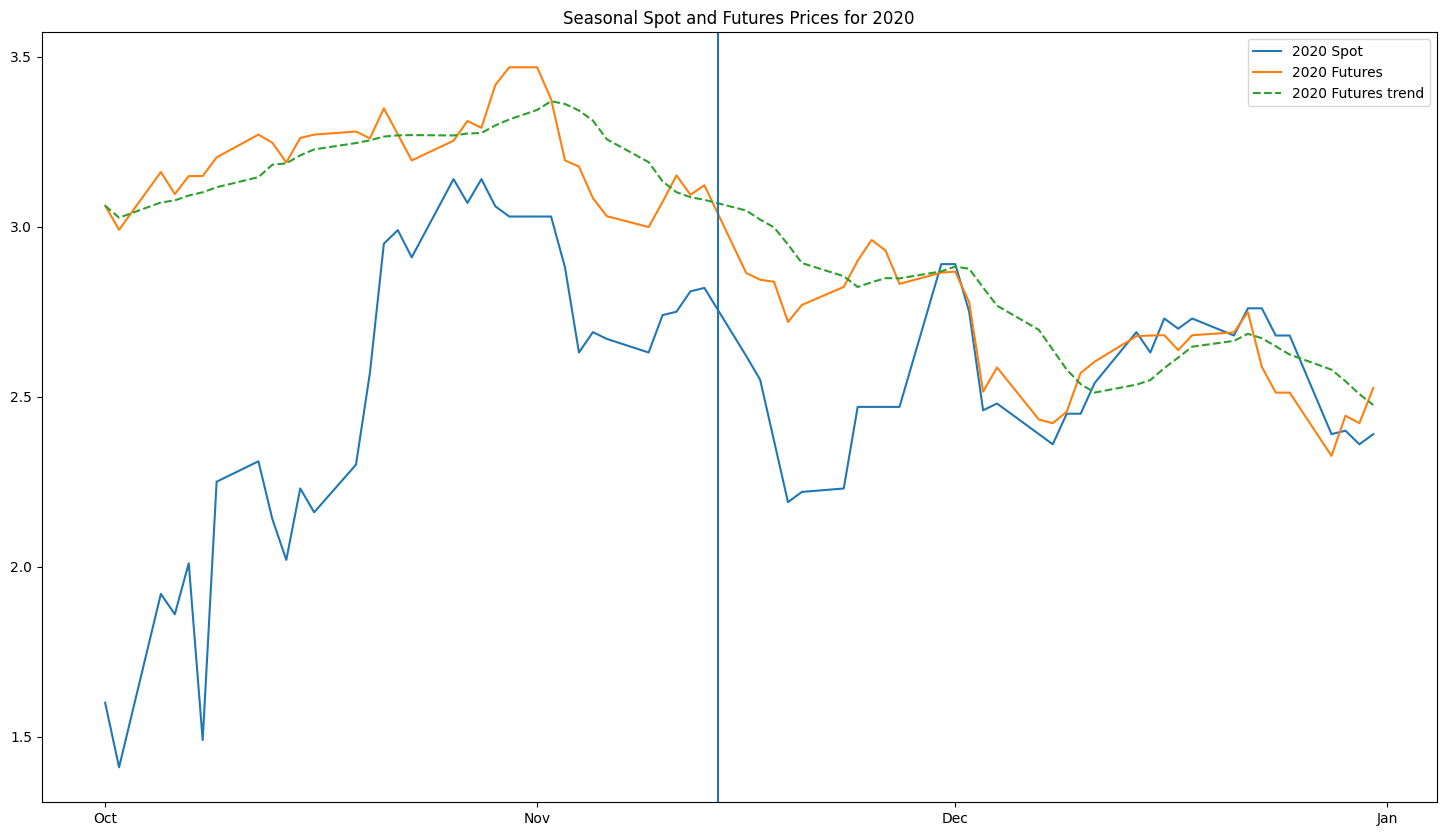

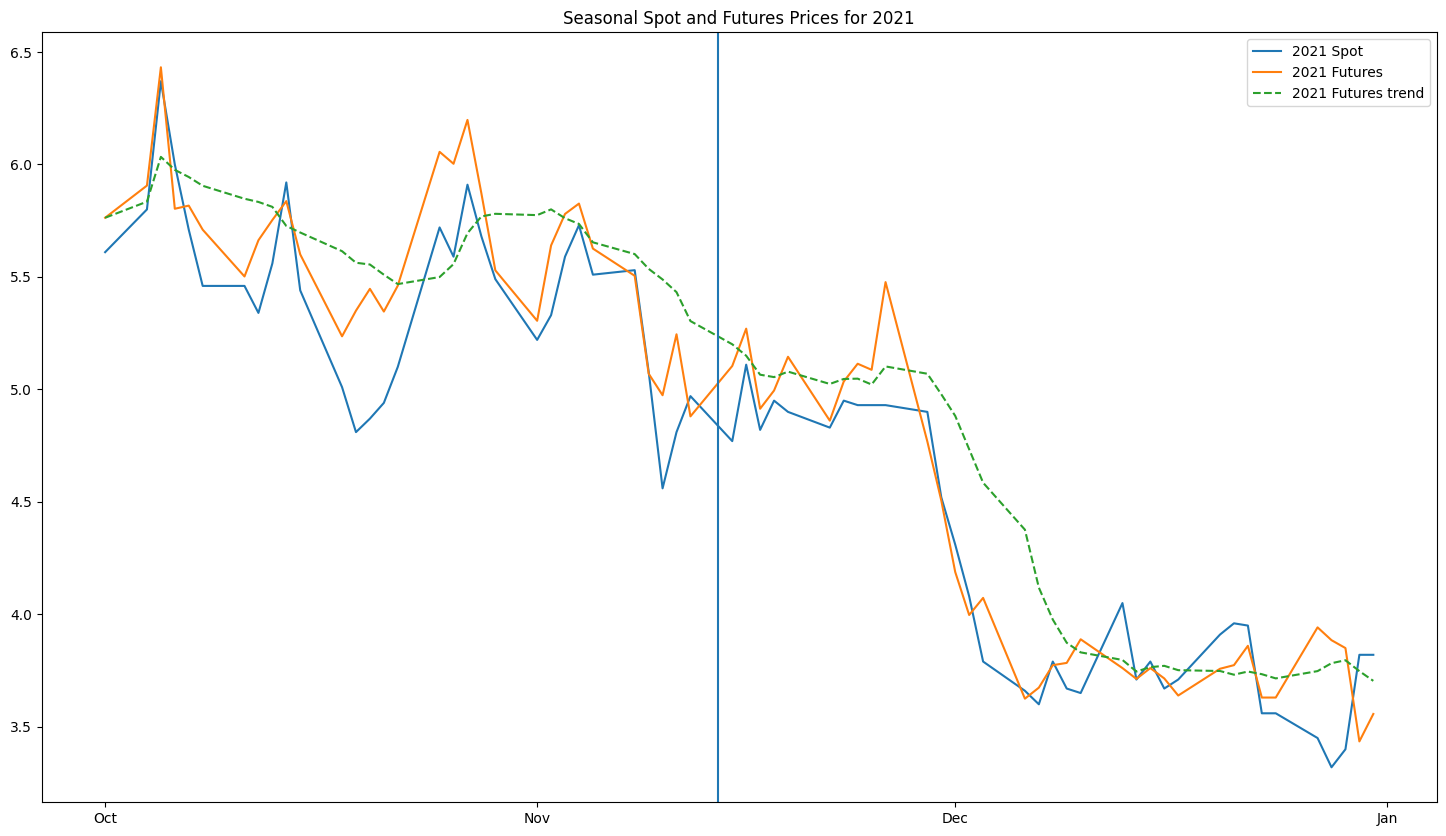

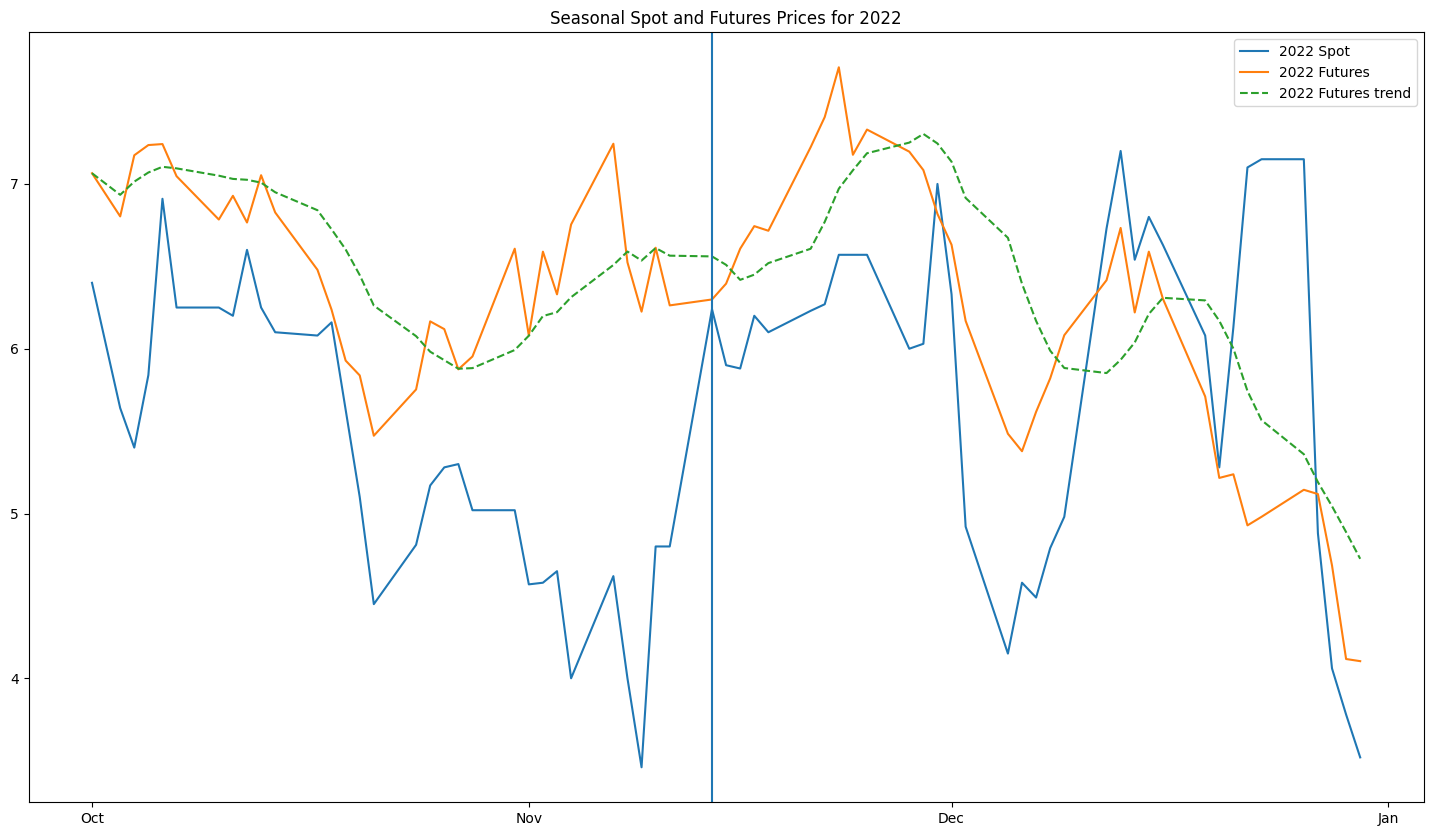

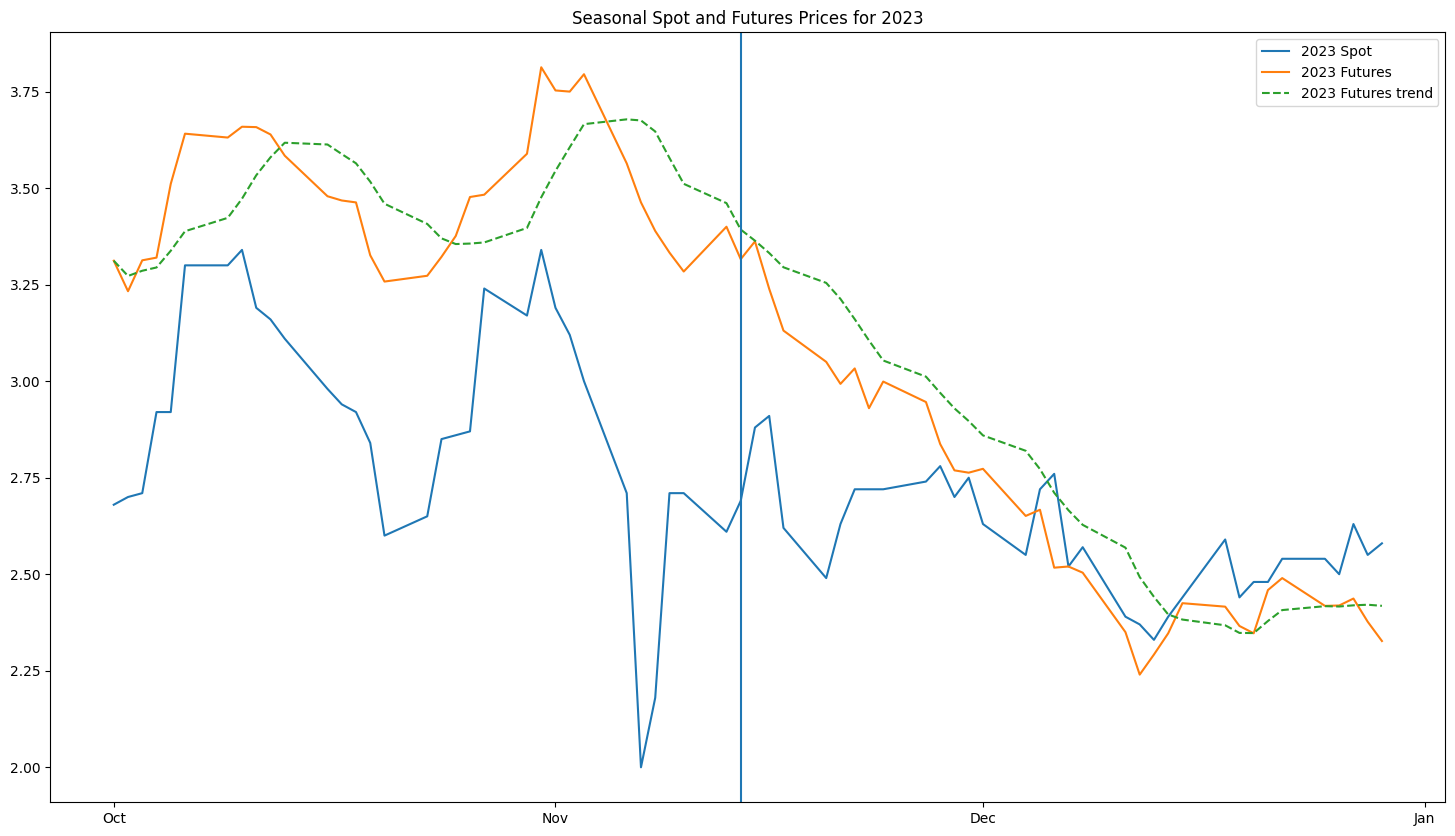

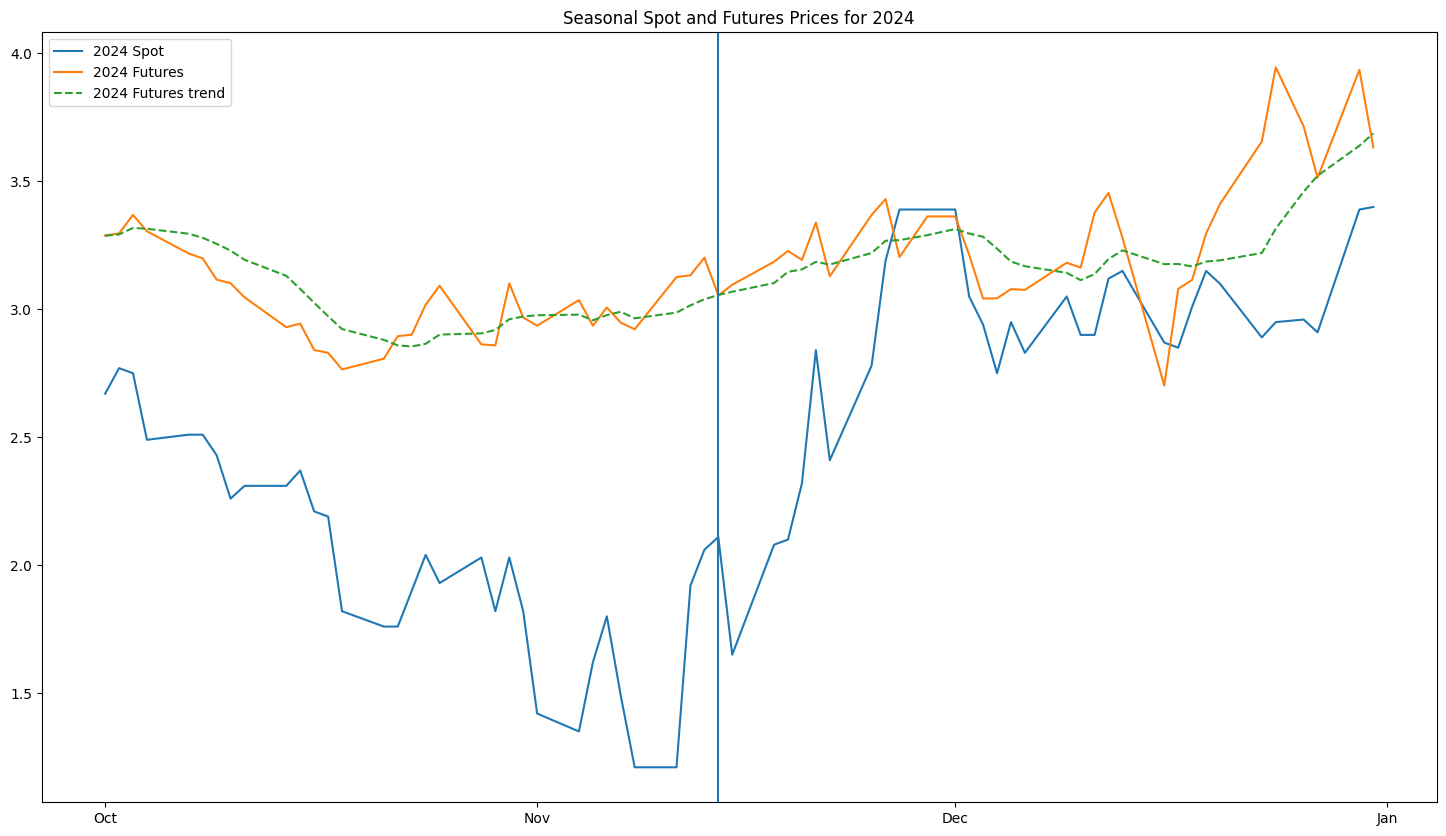

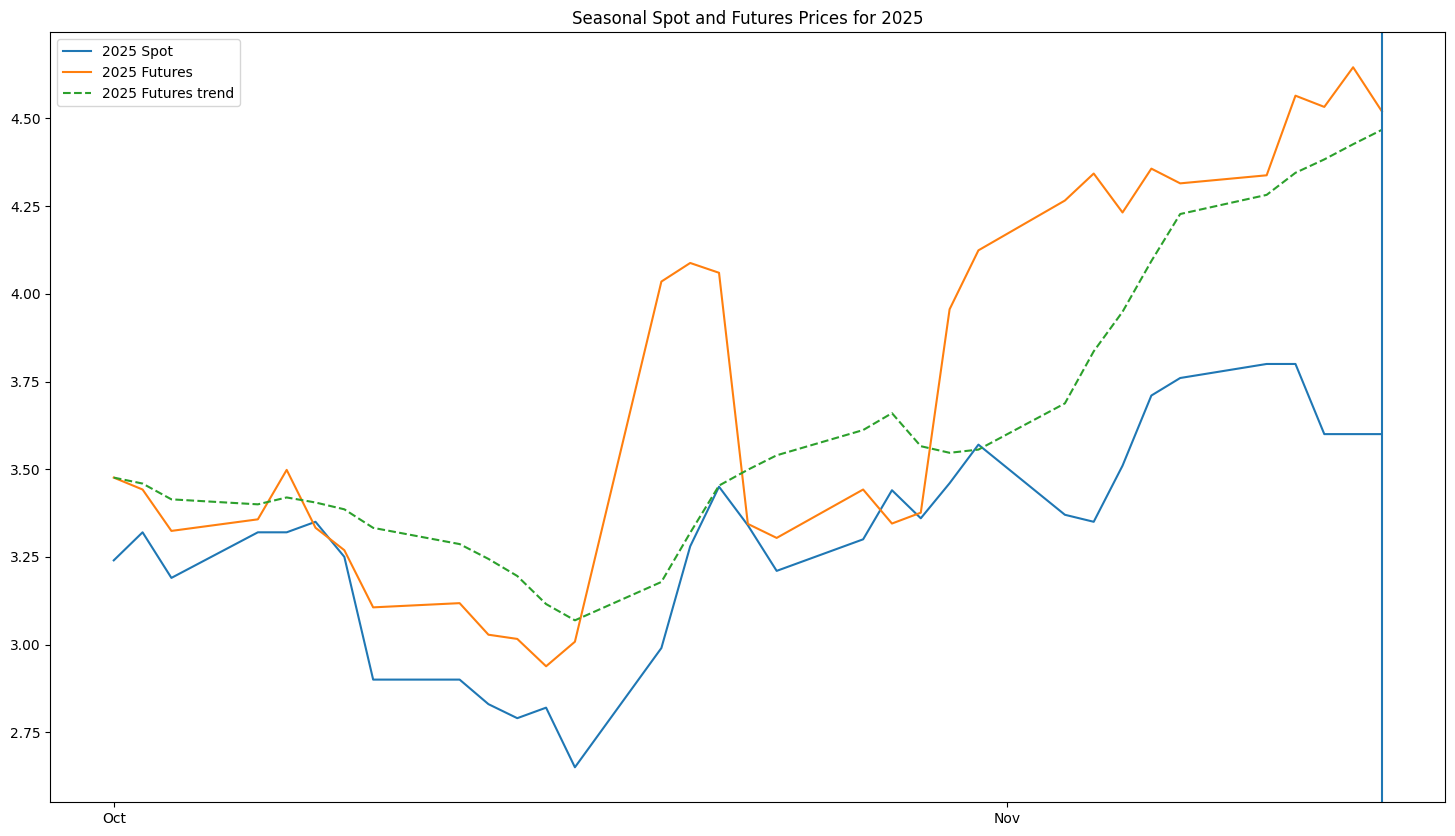

In [114]:
for key in grouped_price_df.groups.keys():
    if key > 2018:
        plt.figure(figsize=(18, 10))
        md_prices = get_prices_for_year(grouped_price_df, 'Henry Hub Natural Gas Spot Price, Daily', key).loc["2000-10-01":"2000-12-31"]
        futures_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key).loc["2000-10-01":"2000-12-31"]
        plt.plot(md_prices, label=f'{key} Spot')
        plt.plot(futures_prices, label=f'{key} Futures')
        
        # trend line for futures
        y = futures_prices.values.astype(float)
        x = np.arange(len(y))  # 0,1,2,... – wystarczy do regresji

        mask = ~np.isnan(y)
        x_fit = x[mask]
        y_fit = y[mask]

        # y = a*x + b
        a, b = np.polyfit(x_fit, y_fit, 1)
        trend = futures_prices.rolling(7, min_periods=1).mean()

        plt.plot(
            futures_prices.index,
            trend,
            '--',
            label=f'{key} Futures trend'
        )
        
        plt.title(f'Seasonal Spot and Futures Prices for {key}')
        plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day))
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        plt.show()

In [125]:
all_years = []
years = []
for key in grouped_price_df.groups.keys():
    if key > 2015:
        md_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key)
        md_prices = md_prices / md_prices.iloc[0]
        all_years.append(md_prices)
        # years.append(key)

all_years_df = pd.concat(all_years, axis=1)

In [126]:
# Sanity check
all_years_df.head()

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
2000-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2000-01-02,NaN,0.939850,0.964633,0.948692,0.960532,1.000000,1.000000,1.009503,0.894638,1.007432
2000-01-03,NaN,0.893394,0.951006,0.942991,0.969252,NaN,1.034017,0.887183,0.917885,0.923204
2000-01-04,0.998716,0.877282,0.912719,0.974178,NaN,1.013856,1.007028,0.921053,0.959505,NaN
2000-01-05,0.994865,0.878894,0.890655,NaN,NaN,1.058195,1.043014,0.834795,0.982752,NaN


Plotting min, mean and max prices through year with normalized prices

<Figure size 1500x1000 with 0 Axes>

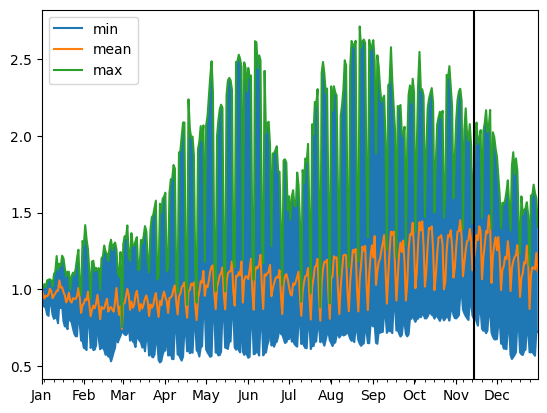

In [ ]:
all_years_df['mean'] = all_years_df.mean(axis=1, skipna=True)
all_years_df['min'] = all_years_df.min(axis=1, skipna=True)
all_years_df['max'] = all_years_df.max(axis=1, skipna=True)
all_years_df.sort_index()

plt.figure(figsize=(15, 10))
all_years_df.plot(y=["min", "mean", "max"], kind="line")
plt.fill_between(all_years_df.index, all_years_df["min"], all_years_df["max"])
# plt.ylim(0, 3)
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day), color='black')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

Plotting the same without normalization

<Figure size 1500x1000 with 0 Axes>

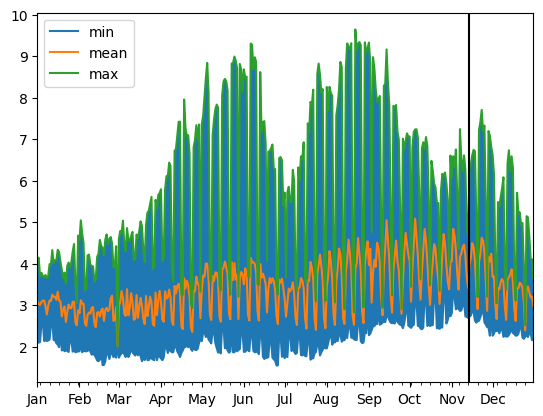

In [129]:
all_years = []
years = []
for key in grouped_price_df.groups.keys():
    if key > 2018:
        md_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key)
        md_prices = md_prices
        all_years.append(md_prices)
        # years.append(key)

all_years_df = pd.concat(all_years, axis=1)

all_years_df['mean'] = all_years_df.mean(axis=1, skipna=True)
all_years_df['min'] = all_years_df.min(axis=1, skipna=True)
all_years_df['max'] = all_years_df.max(axis=1, skipna=True)
all_years_df.sort_index()

plt.figure(figsize=(15, 10))
all_years_df.plot(y=["min", "mean", "max"], kind="line")
plt.fill_between(all_years_df.index, all_years_df["min"], all_years_df["max"])
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day), color='black')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

This doesn't give too much insight. Let's see the weekly fluctuation in price - if mean on specific day can be higher or lower

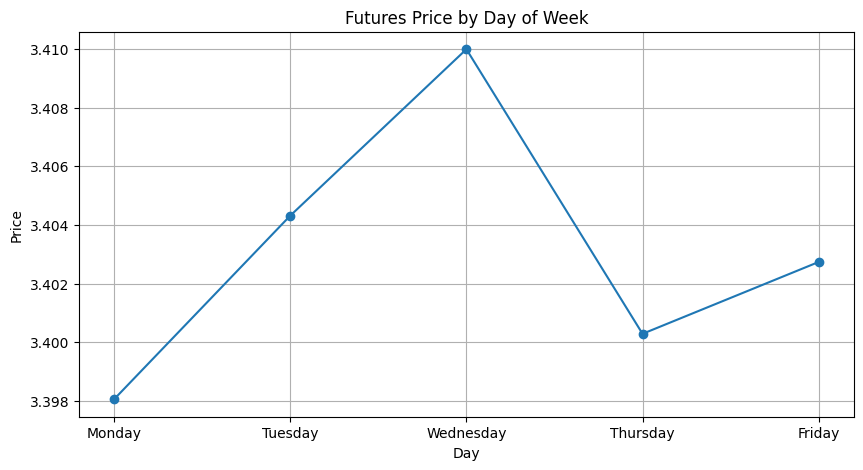

In [139]:
# assume df.index is a DatetimeIndex
weekday_df = all_data_df[['Futures Price']].copy()
weekday_df['weekday'] = weekday_df.index.day_name()

# group and compute mean (or median)
weekday_avg = weekday_df.groupby('weekday')['Futures Price'].mean()

# reorder to natural week order
order = ['Monday','Tuesday','Wednesday','Thursday','Friday']
weekday_avg = weekday_avg.loc[order]

# plot
plt.figure(figsize=(10, 5))
plt.plot(weekday_avg.index, weekday_avg.values, marker='o')
plt.title('Futures Price by Day of Week')
plt.xlabel('Day')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## Creating dataframe with chosen series ready for learning NN

In [ ]:
chosen_data_list = []
for series_id in ALL_IDS:
    chosen_data_list.append(read_row_of_data(row_id=series_id))
chosen_data_df = pd.concat(chosen_data_list, axis=1, join='outer')

In [ ]:
chosen_data_df = chosen_data_df.sort_index()
chosen_data_df = chosen_data_df.fillna(method='ffill')
chosen_data_df = chosen_data_df.loc[:, ~
                                     chosen_data_df.columns.duplicated()].copy()
chosen_data_df = chosen_data_df[~chosen_data_df[['Henry Hub Natural Gas Spot Price, Daily',
                                        'Natural Gas Futures Contract 1, Daily', 'Natural Gas Futures Contract 2, Daily']].isna().any(axis=1)]

In [ ]:
# Adding properties of date as input data
chosen_data_df['Day of the week'] = chosen_data_df.index.dayofweek
chosen_data_df['Day'] = chosen_data_df.index.day
chosen_data_df['Month'] = chosen_data_df.index.month

Overview of chosen data

In [ ]:
chosen_data_df.columns

In [ ]:
# Filtering out data before 2001 because they lack most of the informations
chosen_data_df = chosen_data_df[chosen_data_df.index >= datetime.datetime(2001, 1, 1)]

Plotting histograms and boxplots for chosen series

In [ ]:
import seaborn as sns

for column in chosen_data_df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.histplot(chosen_data_df[column], ax=ax1)
    sns.boxplot(chosen_data_df[column], ax=ax2)
    plt.show()

As you can see most of the data has more or less gaussian distribution.

Prices for different contracts as well as exports and number of wells drilled has significant number of outliers.

Scalling of data. As Prices and Exports series has a lot of outliers they need to be treated with robust scalling. Rest of data is scaled with standard scaler.

In [ ]:
from sklearn import preprocessing

columns_for_robust_scalling = ['Henry Hub Natural Gas Spot Price, Daily',
                               'Natural Gas Futures Contract 4, Daily',
                               'Natural Gas Futures Contract 3, Daily',
                               'Natural Gas Futures Contract 2, Daily',
                               'Natural Gas Futures Contract 1, Daily',
                               'U.S. Natural Gas Exports, Monthly',
                               'U.S. Natural Gas Exploratory and Developmental Wells Drilled, Monthly']
other_columns = [
    column for column in chosen_data_df.columns if column not in columns_for_robust_scalling]
min_max_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler(quantile_range=(0.0, 75.0))
robust_scaled_data = pd.DataFrame(robust_scaler.fit_transform(
    chosen_data_df[columns_for_robust_scalling]), columns=columns_for_robust_scalling, index=chosen_data_df.index)
min_max_scaled_data = pd.DataFrame(min_max_scaler.fit_transform(
    chosen_data_df[other_columns]), columns=other_columns, index=chosen_data_df.index)
chosen_data_df_scaled = pd.merge(robust_scaled_data, min_max_scaled_data, left_index=True, right_index=True)

In [ ]:
# Adding target column to df - NG price in next session
chosen_data_df_scaled['Future 1 in one day'] = chosen_data_df['Natural Gas Futures Contract 1, Daily'].shift(
    -1) - chosen_data_df['Natural Gas Futures Contract 1, Daily']
# chosen_data_df_scaled['Future 1 in one day'] = chosen_data_df['Natural Gas Futures Contract 1, Daily'].shift(
#     -1)

In [ ]:
chosen_data_df_scaled = chosen_data_df_scaled.fillna(0)

Creating plot of NG price depending on different series to see if there's any correlation

In [ ]:
from IPython.display import Image

pp = sns.pairplot(data=chosen_data_df,
                  y_vars=['Natural Gas Futures Contract 1, Daily'],
                  x_vars=chosen_data_df.columns)
for ax in pp.axes.flat:
    ax.tick_params(labelrotation=45, labelsize=7)
    ax.set_xlabel(xlabel=ax.get_xlabel(), rotation=45, fontsize=8)
pp.savefig('Price correlations.png')

plt.clf()
Image(filename='Price correlations.png')

As you can see there's pretty much no visible relationships between series and price of given contract apart apart from other contracts.

In [ ]:
# If you want bigger pair plot and more insight you can uncomment this one
# from IPython.display import Image
# import seaborn as sns
# import matplotlib.pyplot as plt 

# sns_plot = sns.pairplot(chosen_data_df_scaled, height=2.0)
# sns_plot.savefig("pairplot.png")

# plt.clf() # Clean parirplot figure from sns 
# Image(filename='pairplot.png') # Show pairplot as image

In [ ]:
# Putting data into time series with batch containing 50 sessions

x_batches = np.array([chosen_data_df_scaled.iloc[i*50:].head(50).drop(columns=[
                     'Future 1 in one day']).values for i in range(floor(len(chosen_data_df_scaled)/50))])
y_batches = np.array([chosen_data_df_scaled['Future 1 in one day'].iloc[i*50:].head(
    50).values for i in range(floor(len(chosen_data_df_scaled)/50))])
y_batches = np.expand_dims(y_batches, -1)

In [ ]:
# Splitting data into train, val and test sets in 80-10-10 ratio
x_train, x_val, y_train, y_val = train_test_split(
    x_batches, y_batches, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)

In [ ]:
import tensorflow as tf

# Metric to check if prediction was in the right direction (ie price goes up or down)
def sign_metric(y_true, y_pred):
    return tf.reduce_mean(tf.cast((((y_true== y_pred) & (y_true==0)) | (y_true*y_pred>0)), tf.float32), axis=-1)

Creating model with early stopping and checkpointing to predict NG price change. I tried various amount of LSTM cells in process but they gave pretty much the same results.

In [ ]:
inputs = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
x = tf.keras.layers.LSTM(2, return_sequences=True, stateful=False)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-4), loss="mae", metrics=[sign_metric])
history = model.fit(x_train, y_train, batch_size=2, epochs=500, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_sign_metric', save_best_only=True, save_weights_only=True, mode='max')])
model.load_weights('best_model.h5')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(x_test, y_test)
y_hat_test = model.predict(x_test)

As evaluation on test set shows - this model has MAE's value of 0.41 which is very big and on top of that it correctly predicts direction of change of price only in 47% of cases. It is much too inaccurate to use it in some sort of trading help.

I will try to get more insight to results in following cells

In [ ]:
standarized_price = x_test[:,:,4].ravel()
array_to_inverse = np.zeros((standarized_price.shape[0], 7))
array_to_inverse[:, 4] = standarized_price
current_prices = robust_scaler.inverse_transform(array_to_inverse)[:, 4]
next_day_prices = np.roll(current_prices, -1)
next_day_prices[-1] = np.NaN

In [ ]:
unrolled_y_test = np.array(y_test).ravel()
unrolled_y_hat_test = np.array(y_hat_test).ravel()
comparision_columns = list(zip(unrolled_y_test, unrolled_y_hat_test, current_prices, next_day_prices, unrolled_y_test-unrolled_y_hat_test, (unrolled_y_test-unrolled_y_hat_test)/next_day_prices, unrolled_y_hat_test-np.roll(unrolled_y_test, -1), unrolled_y_test-np.roll(unrolled_y_test, -1), ((unrolled_y_test == unrolled_y_hat_test) | (unrolled_y_test*unrolled_y_hat_test>0))))
comparision_dataframe = pd.DataFrame(data=comparision_columns, columns=['true price change','prediction', 'current price', 'next day price', 'difference between true price and prediction','relative difference','predicted daily change','true daily change', 'is same direction?'])
display(comparision_dataframe.head(5))

In [ ]:
print(len(comparision_dataframe.loc[(comparision_dataframe['relative difference'].abs() > 0.05) & (~comparision_dataframe['is same direction?'])]))
print(len(comparision_dataframe.loc[(comparision_dataframe['relative difference'].abs() > 0.05) & (comparision_dataframe['is same direction?'])]))

In [ ]:
plt.boxplot(comparision_dataframe['difference between true price and prediction'], showfliers=False)
plt.show()

Relative mistakes higher than 5% occurs very often and more frequently with incorrect direction. Median of difference between true change and prediction is not even around 0

### As you can see - unfortunately this approach doesn't work. Chosen series of data provided by EIA isn't enough to predict change of NG price. 

Next I will try to approach this as classification problem (price go up/down/stay the same) and use all of the series provided in file.

## Classification approach

In [ ]:
y_classes = np.concatenate((y_batches < 0, y_batches==0, y_batches>0),axis=-1).astype(np.int8)

# Splitting data into train, val and test sets in 80-10-10 ratio
x_class_train, x_class_val, y_class_train, y_class_val = train_test_split(
    x_batches, y_classes, test_size=0.2)
x_class_val, x_class_test, y_class_val, y_class_test = train_test_split(x_class_val, y_class_val, test_size=0.5)

In [ ]:
inputs = tf.keras.Input(shape=(x_class_train.shape[1], x_class_train.shape[2]))
x = tf.keras.layers.LSTM(4, return_sequences=True, stateful=False)(inputs)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model.fit(x_class_train, y_class_train, batch_size=8, epochs=500, validation_data=(x_class_val, y_class_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='best_class_model.h5', monitor='categorical_accuracy', save_best_only=True, save_weights_only=True, mode='max')])
model.load_weights('best_class_model.h5')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(x_class_test, y_class_test)

### This approach also doesn't work. It reaches accuracy over 50% but it's too small confidence to use this model

Let's try to use one last approach. Classification (as it's easier) with all the data provided by EIA

## Classification with all the data

In [ ]:
from sklearn import preprocessing

columns_for_robust_scalling = ['Henry Hub Natural Gas Spot Price, Daily',
                               'Natural Gas Futures Contract 4, Daily',
                               'Natural Gas Futures Contract 3, Daily',
                               'Natural Gas Futures Contract 2, Daily',
                               'Natural Gas Futures Contract 1, Daily',
                               'U.S. Natural Gas Exports, Monthly',
                               'U.S. Natural Gas Exploratory and Developmental Wells Drilled, Monthly']
other_columns = [
    column for column in all_data_df.columns if column not in columns_for_robust_scalling]
min_max_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler(quantile_range=(0.0, 75.0))
robust_scaled_data = pd.DataFrame(robust_scaler.fit_transform(
    all_data_df[columns_for_robust_scalling]), columns=columns_for_robust_scalling, index=all_data_df.index)
min_max_scaled_data = pd.DataFrame(min_max_scaler.fit_transform(
    all_data_df[other_columns]), columns=other_columns, index=all_data_df.index)
all_data_df_scaled = pd.merge(robust_scaled_data, min_max_scaled_data, left_index=True, right_index=True)

In [ ]:
# Adding target column to df - NG price in next session
all_data_df_scaled['Future 1 in one day'] = all_data_df['Natural Gas Futures Contract 1, Daily'].shift(
    -1) - all_data_df['Natural Gas Futures Contract 1, Daily']
# chosen_data_df_scaled['Future 1 in one day'] = chosen_data_df['Natural Gas Futures Contract 1, Daily'].shift(
#     -1)

In [ ]:
all_data_df_scaled = all_data_df_scaled.fillna(0)

In [ ]:
# Putting data into time series with batch containing 50 sessions

all_data_x_batches = np.array([all_data_df_scaled.iloc[i*50:].head(50).drop(columns=[
                     'Future 1 in one day']).values for i in range(floor(len(all_data_df_scaled)/50))])
all_data_y_batches = np.array([all_data_df_scaled['Future 1 in one day'].iloc[i*50:].head(
    50).values for i in range(floor(len(all_data_df_scaled)/50))])
all_data_y_batches = np.expand_dims(all_data_y_batches, -1)

In [ ]:
all_data_y_classes = np.concatenate((all_data_y_batches < 0, all_data_y_batches==0, all_data_y_batches>0),axis=-1).astype(np.int8)

# Splitting data into train, val and test sets in 80-10-10 ratio
all_data_x_class_train, all_data_x_class_val, all_data_y_class_train, all_data_y_class_val = train_test_split(
    all_data_x_batches, all_data_y_classes, test_size=0.2)
all_data_x_class_val, all_data_x_class_test, all_data_y_class_val, all_data_y_class_test = train_test_split(all_data_x_class_val, all_data_y_class_val, test_size=0.5)

In [ ]:
all_data_x_batches.shape

All data contains over 15000 attributes. Network has to be pretty large.

In [ ]:
inputs = tf.keras.Input(shape=(all_data_x_class_train.shape[1], all_data_x_class_train.shape[2]))
x = tf.keras.layers.LSTM(128, return_sequences=True, stateful=False)(inputs)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model.fit(all_data_x_class_train, all_data_y_class_train, batch_size=8, epochs=500, validation_data=(all_data_x_class_val, all_data_y_class_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='all_data_best_class_model.h5', monitor='categorical_accuracy', save_best_only=True, save_weights_only=True, mode='max')])
model.load_weights('all_data_best_class_model.h5')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(all_data_x_class_test, all_data_y_class_test)

## As expected, using all of the possible data had negative effect on accuracy of prediction of price change. It is the worst model of all created in this notebook.

My understanding is that network had hard time recognizing which attributes were significant and choosing them. Smaller set of attributes gives better probability of getting better model as optimizer has smaller set of paths to go through to optimal solution.

# Summary

## It is not possible to predict Natural Gas price changes for next NYMEX session by using only EIA data.

### It seems like price depends more on speculation, geopolitical news and psychology than hard data about use and distribution of natural gas. Especially given the fact that data used here is registered in hindsight.

# Thank you for your attention